# 8.25.22

In [1]:
import glob
import importlib
import os
import random
import sys
from itertools import combinations

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import prettypyplot as pplt
import seaborn as sns
from matplotlib import ticker

import extq
import ivac

In [2]:
sys.path.insert(1, "/project/dinner/scguo/ci-vsd/python/")
import util
import plotting

In [3]:
pplt.load_cmaps()
plt.style.use("custom")  # custom style sheet
plt.style.use("muted")  # muted color theme from SciencePlots
colors = mpl.colors.to_rgba_array(
    [
        "#364B9A",
        "#4A7BB7",
        "#6EA6CD",
        "#98CAE1",
        "#C2E4EF",
        "#EAECCC",
        "#FEDA8B",
        "#FDB366",
        "#F67E4B",
        "#DD3D2D",
        "#A50026",
    ]
)
cm_div = mpl.colors.LinearSegmentedColormap.from_list("diverging", colors)
mpl.colormaps.register(cm_div)

# Load data

In [4]:
DATA_DIR = "/project/dinner/scguo/ci-vsd/data"
# S4 translocation/rotation data
cv_trajs = list(
    np.load(f"{DATA_DIR}/raw_feat/cv_dist_spin_anton.npy", allow_pickle=True)
)
cv_trajs.extend(np.load(f"{DATA_DIR}/raw_feat/cv_dist_spin_anton2.npy"))
cv_arr = np.concatenate(cv_trajs)
# salt bridge distances for states
sb_trajs = list(np.load(f"{DATA_DIR}/raw_feat/feat2_raw_anton.npy", allow_pickle=True))
sb_trajs.extend(np.load(f"{DATA_DIR}/raw_feat/feat2_raw_anton2.npy"))
sb_arr = np.concatenate(sb_trajs)
sb_models = np.load(f"{DATA_DIR}/models_centroids_feat2.npy")
# distances to F161
rf161 = list(np.load(f"{DATA_DIR}/raw_feat/rf161.npy", allow_pickle=True))
rf161.extend(np.load(f"{DATA_DIR}/raw_feat/rf161_anton2.npy"))
rf161_arr = np.concatenate(rf161)
# committors
lag = 500
qp_du = np.load(f"{DATA_DIR}/feat2_dist_du_anton2/qp_downup_3.npy", allow_pickle=True)[8] # 50 ns lag time
# weights
weights = np.load(f"{DATA_DIR}/feat2_dist_du_anton2/weights_3_feat5ivac.npy", allow_pickle=True)[0] # 0.1 ns lag time

In [5]:
feature_names = []
feature_names.append('Translocation')
feature_names.append('Rotation')
for r in ("R217", "R223", "R226", "R229", "R232"):
    for n in ("D129", "D136", "D151", "D164", "E183", "D186"):
        if n.startswith("D"):
            feature_names.append(f"{r} C$_\\zeta$-{n} C$_\\gamma$")
        else:
            feature_names.append(f"{r} C$_\\zeta$-{n} C$_\\delta$")
for i in ("R223", "R226", "R229"):
    feature_names.append(f"{i}-F161")

In [6]:
sb_ids = [42, 47, 52, 53, 58, 59]
feat_arr = np.hstack((cv_arr, sb_arr[:, sb_ids], rf161_arr[:, 1:2]))
q_arr = np.concatenate(qp_du)
print(feat_arr.shape, q_arr.shape)

(4150115, 9) (4150115,)


In [7]:
traj_inds = util.split_indices(cv_trajs)
feat_trajs = np.split(feat_arr, traj_inds)

In [21]:
ivac_estimator = ivac.LinearIVAC(minlag=10, maxlag=1000, nevecs=3, adjust=True)
ivac_estimator.fit(feat_trajs)
ivac_trajs = ivac_estimator.transform(feat_trajs)

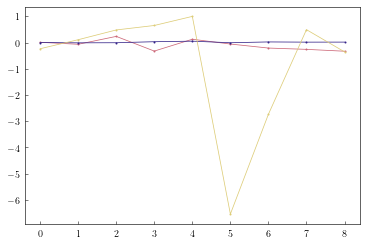

In [26]:
for i in range(3):
    plt.plot(ivac_estimator.evecs[i], '.-')

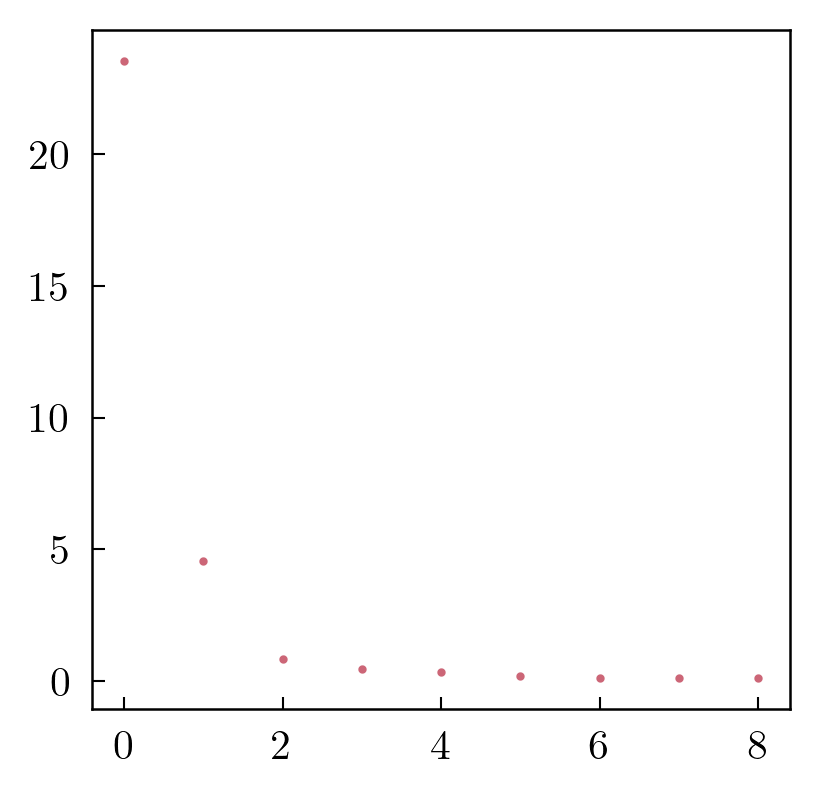

In [9]:
fig = plt.figure(figsize=(3, 3), dpi=300)
plt.plot(ivac_estimator.its * 0.0001, '.')

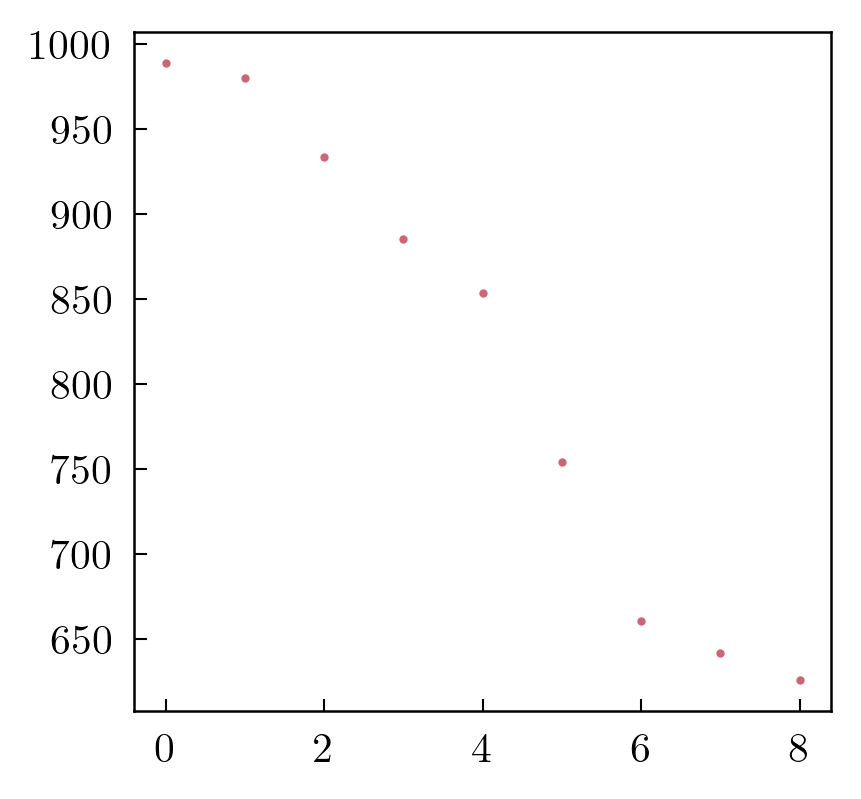

In [10]:
fig = plt.figure(figsize=(3, 3), dpi=300)
plt.plot(ivac_estimator.evals, '.')

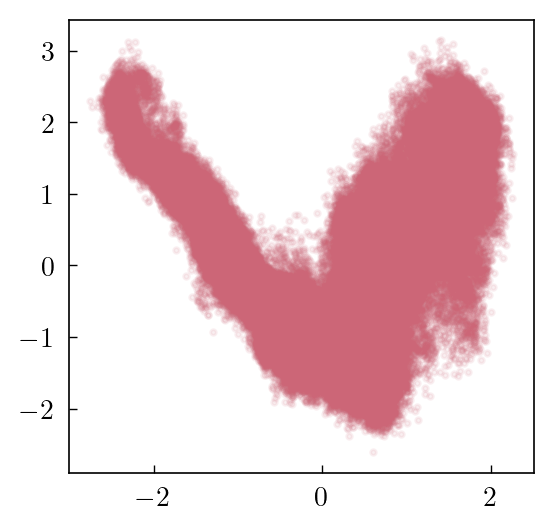

In [11]:
fig = plt.figure(figsize=(3, 3), dpi=200)
ivac_arr = np.concatenate(ivac_trajs)
plt.scatter(ivac_arr[::20, 1], ivac_arr[::20, 2], alpha=0.1)

In [12]:
# get location of states
cv_models = np.loadtxt("/project/dinner/scguo/ci-vsd/models/MD-clustering-center/all.txt")
rf_models = np.load(f"{DATA_DIR}/models_centroids_rf161.npy")
models = np.hstack((cv_models, sb_models[:, sb_ids], rf_models[:, 1:2]))

In [13]:
ivac_models = ivac_estimator.transform([models])[0]

/project/dinner/scguo/extq/src/extq/projection.py:140: RuntimeWarning: invalid value encountered in true_divide
  return numer / denom


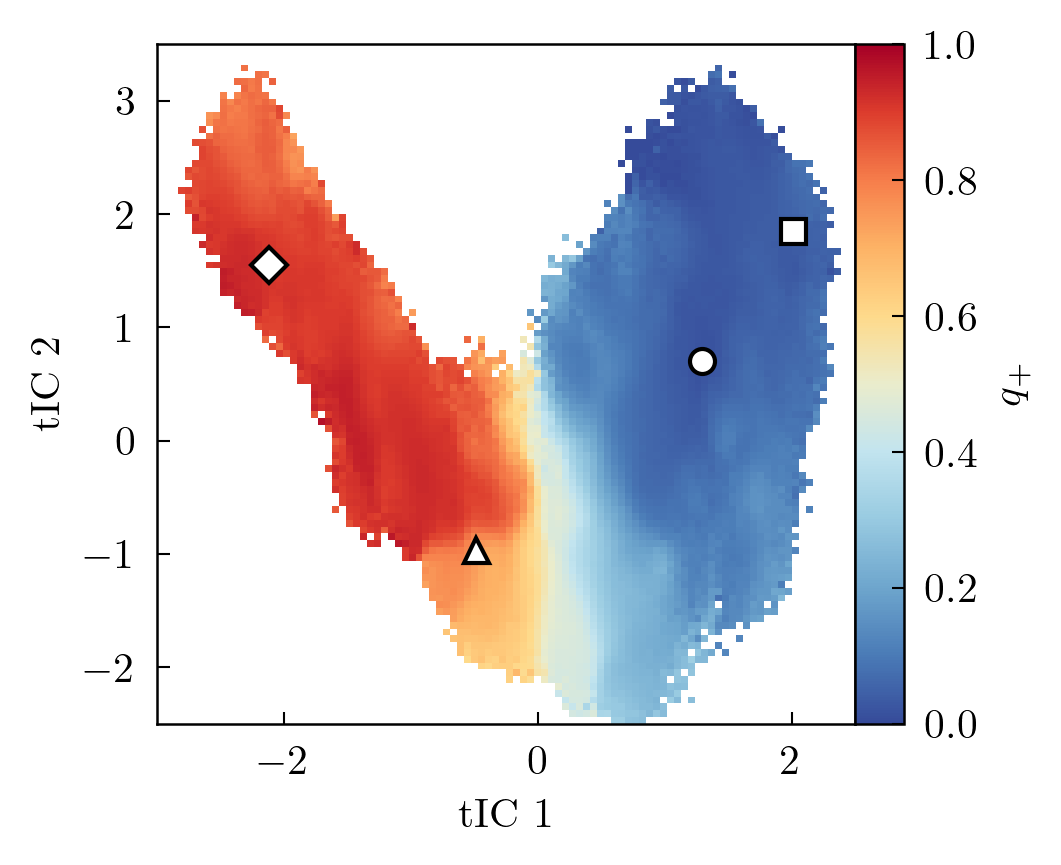

In [14]:
fig = plt.figure(figsize=(3, 3), dpi=300)

ivac_1 = [t[:, 1] for t in ivac_trajs]
ivac_2 = [t[:, 2] for t in ivac_trajs]
xe = np.linspace(-3, 2.5, 101)
ye = np.linspace(-2.5, 3.5, 101)
q_avg = extq.projection.average2d(ivac_1, ivac_2, qp_du, weights, xe, ye)
pc = plt.pcolormesh(xe, ye, q_avg.T, cmap='diverging', vmin=0, vmax=1)
ax = plt.gca()
plotting.plot_models(ax, ivac_models[:, 1:3], ms=6)
plt.xlabel("tIC 1")
plt.ylabel("tIC 2")
pplt.colorbar(pc, label="$q_+$")

In [15]:
np.save("../../data/raw_feat/ivac_less_feat_10-1000", ivac_trajs)
np.save("../../data/models_ivac_less_feat_10-1000", ivac_models)

/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


# Analyze tics

In [8]:
ivac_trajs = np.load("../../data/raw_feat/ivac_less_feat_10-1000.npy", allow_pickle=True)
ivac_arr = np.concatenate(ivac_trajs)
ivac_models = np.load("../../data/models_ivac_less_feat_10-1000.npy")

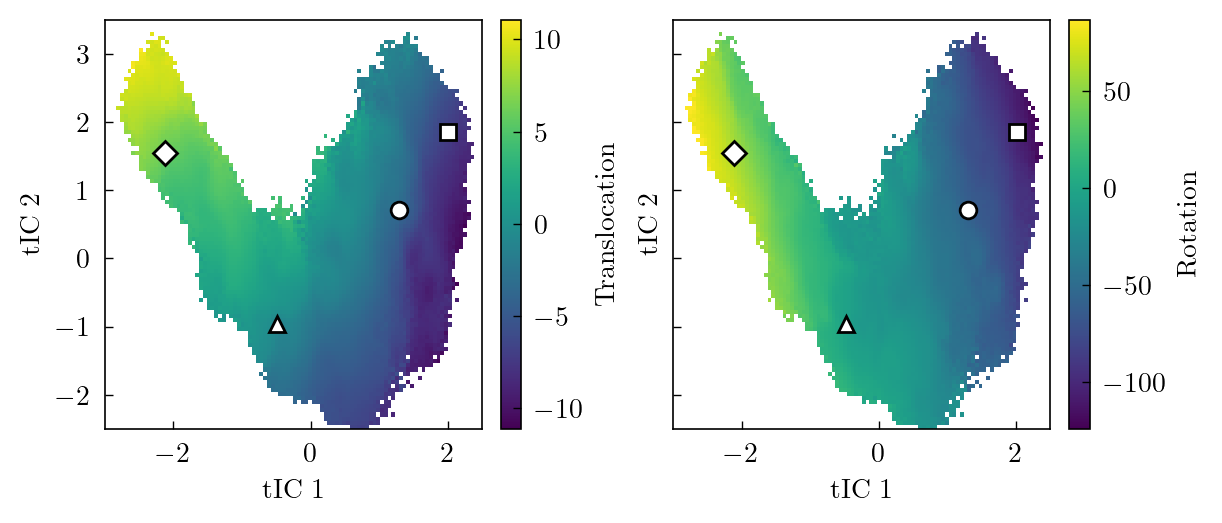

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(6, 2.5), dpi=200, sharex=True, sharey=True, constrained_layout=True)

ivac_1 = [t[:, 1] for t in ivac_trajs]
ivac_2 = [t[:, 2] for t in ivac_trajs]
xe = np.linspace(-3, 2.5, 101)
ye = np.linspace(-2.5, 3.5, 101)
for i in range(2):
    ax = axs[i]
    cvs = [t[:, i] for t in cv_trajs]
    cv_avg = extq.projection.average2d(ivac_1, ivac_2, cvs, weights, xe, ye)
    pc = ax.pcolormesh(xe, ye, cv_avg.T)

    plotting.plot_models(ax, ivac_models[:, 1:3], ms=6)
    ax.set_xlabel("tIC 1")
    ax.set_ylabel("tIC 2")
    plt.colorbar(pc, ax=ax, label=feature_names[i])

/project/dinner/scguo/extq/src/extq/projection.py:140: RuntimeWarning: invalid value encountered in true_divide
  return numer / denom


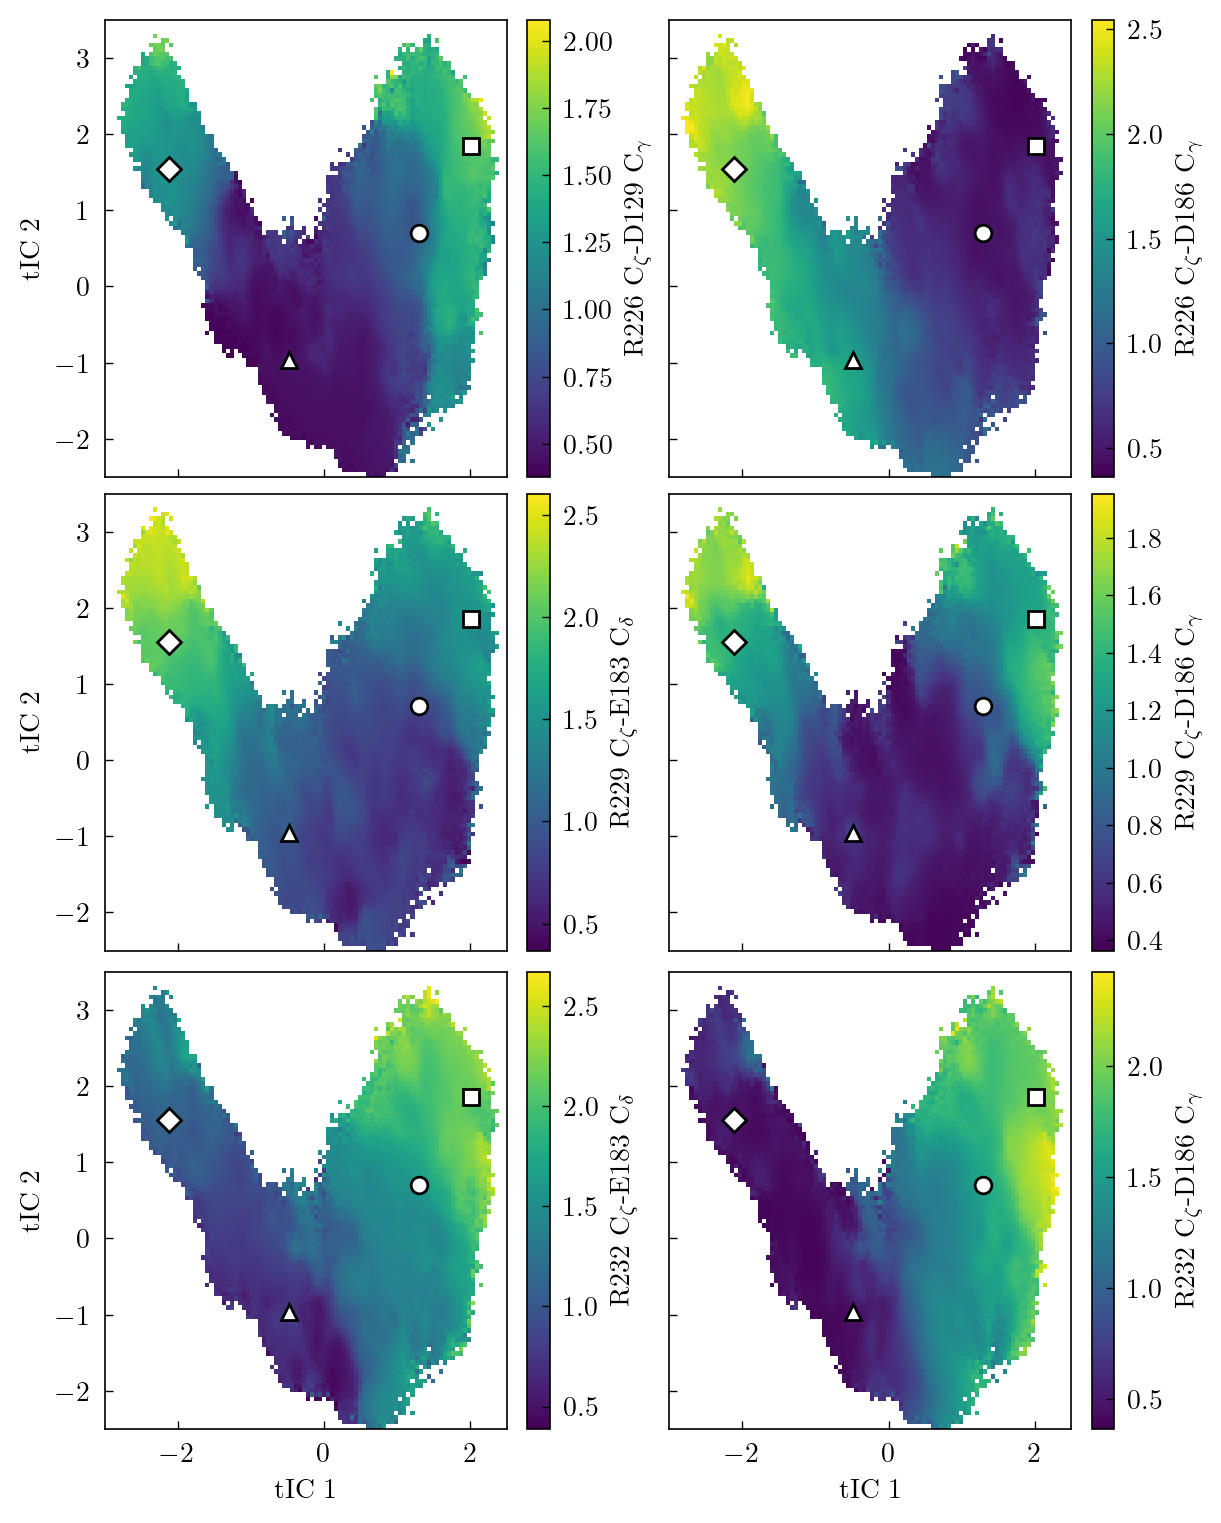

In [20]:
fig, axs = plt.subplots(3, 2, figsize=(6, 7.5), dpi=200, sharex=True, sharey=True, constrained_layout=True)

for i, ax in enumerate(axs.flat):
    cvs = [t[:, sb_ids[i]] for t in sb_trajs]
    cv_avg = extq.projection.average2d(ivac_1, ivac_2, cvs, weights, xe, ye)
    pc = ax.pcolormesh(xe, ye, cv_avg.T)

    plotting.plot_models(ax, ivac_models[:, 1:3], ms=6)
    ax.set_xlabel("tIC 1")
    ax.set_ylabel("tIC 2")
    ax.label_outer()
    plt.colorbar(pc, ax=ax, label=feature_names[sb_ids[i] - 28])